In [8]:
import sys
sys.path.append('../larndsim')
import detsim
import drifting
import quenching
import importlib
importlib.reload(detsim)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import pickle
import numpy as np
import torch 
from tqdm import tqdm_notebook as progress_bar
import consts

In [9]:
tracks = pickle.load(open('FakeTrackDataSet.p', 'rb'))
tracks['t'] = 0
tracks['t_start'] = 0
tracks['t_end'] = 0

tracks['dx'] = np.sqrt(pow(tracks['x_end']-tracks['x_start'], 2) +
                    pow(tracks['y_end']-tracks['y_start'], 2) +
                    pow(tracks['z_end']-tracks['z_start'], 2))
tracks['x'] = (tracks['x_end']+tracks['x_start'])/2
tracks['y'] = (tracks['y_end']+tracks['y_start'])/2
tracks['z'] = (tracks['z_end']+tracks['z_start'])/2
tracks['dE'] = np.abs(tracks['dE'])*1e3
tracks['dEdx'] = tracks['dE']/tracks['dx']
tracks['NElectrons'] = 0
tracks['longDiff'] = 0
tracks['tranDiff'] = 0

dE,dEdx,NElectrons = [np.array(tracks[i], dtype=float) for i in ['dE','dEdx','NElectrons']]
quenching.Quench(dEdx, dE, NElectrons)

z, zStart, zEnd, t, tStart, tEnd = [np.array(tracks[i],dtype=float) for i in ['z','z_start','z_end','t','t_start','t_end']]
longDiff, tranDiff = [np.array(tracks[i],dtype=float) for i in ['longDiff','tranDiff']]

drifting.Drift(NElectrons, z, zStart, zEnd, t, tStart, tEnd, longDiff, tranDiff)

tracks['NElectrons'] = NElectrons
tracks['z']          = z
tracks['z_start']    = zStart
tracks['z_end']      = zEnd
tracks['t']          = t
tracks['t_start']    = tStart
tracks['t_end']      = tEnd
tracks['longDiff']   = longDiff
tracks['tranDiff']   = tranDiff

indeces = {c:i for i, c, in enumerate(tracks.columns)}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
driftedTracks = torch.tensor(tracks.values).to(device)
selectedTracks = driftedTracks[(driftedTracks[:, indeces['trackID']] > 6) & (driftedTracks[:, indeces['trackID']] < 9)]

In [10]:
tpc = detsim.TPC(t_sampling=1, n_pixels=1000, **indeces)
t = selectedTracks[0]
for t in progress_bar(selectedTracks, desc='Processing tracks...'):
    img = tpc.calculateCurrent(t)

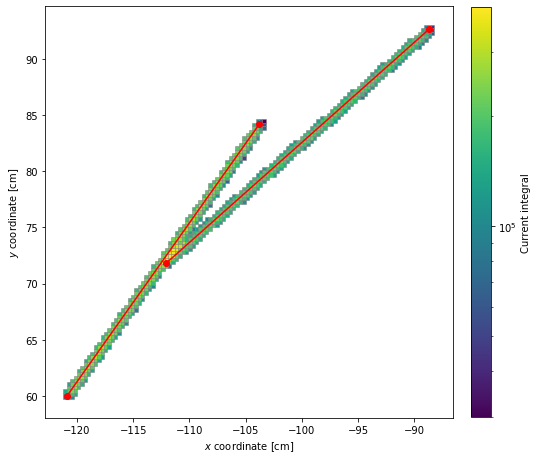

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.set_aspect('equal')

currents = np.array([sum(tpc.getPixelResponse(p)) for p in tpc.activePixels])
norm = mpl.colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for i,p in enumerate(list(tpc.activePixels.keys())):
    rect = plt.Rectangle((p[0]*tpc.x_pixel_size-150,p[1]*tpc.y_pixel_size-150),tpc.x_pixel_size,tpc.y_pixel_size,
                         linewidth=0.5,
                         edgecolor='grey', 
                         facecolor=m.to_rgba(currents[i]), label='Pixel')
    ax.add_patch(rect)
    
for t in selectedTracks:
    ax.plot((t[indeces['x_start']], t[indeces['x_end']]), 
            (t[indeces['y_start']], t[indeces['y_end']]),
            c='r')
    ax.scatter((t[indeces['x_start']].numpy(), t[indeces['x_end']].numpy()), 
               (t[indeces['y_start']].numpy(), t[indeces['y_end']].numpy()),
               c='r', zorder=10)

ax.set_xlabel("$x$ coordinate [cm]")
ax.set_ylabel("$y$ coordinate [cm]")

_ = plt.colorbar(m,fraction=0.046, pad=0.04, label='Current integral')

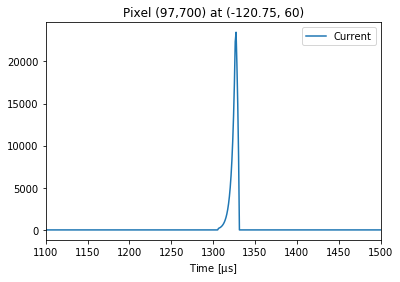

In [12]:
fig, ax = plt.subplots(1,1)
pixelID = tpc.getPixelFromCoordinates(-121,60)
current = tpc.getPixelResponse(pixelID)
ax.plot(tpc.anode_t, current, label='Current')
ax.set_xlim(1100,1500) 
ax.set_title("Pixel (%i,%i) at (%.2f, %2.f)" % (pixelID[0], 
                                      pixelID[1], 
                                      (pixelID[0] + 0.5)*tpc.x_pixel_size-150, 
                                      (pixelID[1] + 0.5)*tpc.y_pixel_size-150))
ax.set_xlabel("Time [$\mathrm{\mu}$s]")
_ = ax.legend()